Learning from: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

using USD_INR exchange rate data

In [1]:
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
%matplotlib inline

import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


# Basic LSTM

In [24]:
dat = pd.read_csv('USD_INR.csv')

In [25]:
dat.head()

,Date,Price,Open,High,Low,Change %
0,"Aug 10, 2017",64.165,63.898,64.175,63.855,0.48
1,"Aug 09, 2017",63.860,63.780,63.860,63.710,0.26
2,"Aug 08, 2017",63.692,63.750,63.785,63.615,-0.23
3,"Aug 07, 2017",63.840,63.710,63.865,63.648,0.26
4,"Aug 04, 2017",63.675,63.670,63.786,63.572,-0.05


In [26]:
p_dat = dat[['Date','Price']]
p_dat['Date'] = pd.to_datetime(p_dat['Date'])

/Users/y0w0252/my-python/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [27]:
p_dat = p_dat.sort_values('Date',ascending=True)

In [28]:
p_dat.head()

,Date,Price
9696,1980-01-02,8.00
9695,1980-01-03,7.95
9694,1980-01-04,8.05
9693,1980-01-07,8.05
9692,1980-01-08,8.05


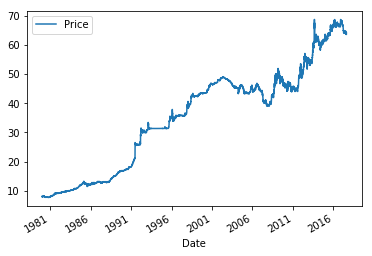

In [32]:
p_dat.plot(x='Date',y='Price')

In [33]:
price_dat = p_dat['Price']

In [34]:
price_dat.head()

9696    8.00
9695    7.95
9694    8.05
9693    8.05
9692    8.05
Name: Price, dtype: float64

In [35]:
print(np.mean(price_dat.values))
print(np.std(price_dat.values))

35.5577077447
17.540190695


### Normalize

In [36]:
price_dat = price_dat.values.ravel().reshape(-1,1)

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))
price_dat = scaler.fit_transform(price_dat)

In [38]:
print(np.mean(price_dat))
print(np.std(price_dat))

0.456077018318
0.286956084989


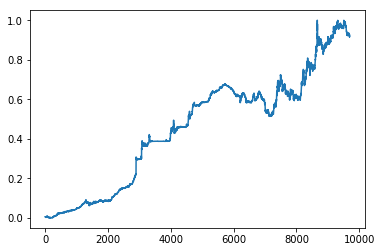

In [39]:
plt.plot(price_dat)

### Train Test Split

In [40]:
ratio = int(round(len(price_dat)*0.8))
print(ratio)

7758


In [41]:
train_dat = price_dat[:ratio]
valid_dat = price_dat[ratio:]

### Creating look back dataset:

In [42]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0] # if look_back=1, look back 1 datapoint,  if look_back=2, look back 2 datapoints
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) # the next point from the look back points
    return np.array(dataX), np.array(dataY)

In [43]:
# reshape into X=t and Y=t+1
look_back = 1 # using past 1 value to predict the next

trainX, trainY = create_dataset(train_dat, look_back)
testX, testY = create_dataset(valid_dat, look_back)

In [44]:
print(trainX.shape)
print(trainY.shape)

(7756, 1)
(7756,)


In [45]:
trainX[:5,:]

array([[ 0.00523517],
       [ 0.00441718],
       [ 0.00605317],
       [ 0.00605317],
       [ 0.00605317]])

In [46]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [47]:
print(trainX.shape)


(7756, 1, 1)


In [48]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # 4 in here means 4 LSTM blocks or neurons
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 37s - loss: 0.0031
Epoch 2/100
 - 35s - loss: 1.0981e-05
Epoch 3/100
 - 35s - loss: 1.0927e-05
Epoch 4/100
 - 37s - loss: 1.0966e-05
Epoch 5/100
 - 38s - loss: 9.8991e-06
Epoch 6/100
 - 38s - loss: 9.8438e-06
Epoch 7/100
 - 35s - loss: 9.5972e-06
Epoch 8/100
 - 37s - loss: 9.1833e-06
Epoch 9/100
 - 37s - loss: 8.7126e-06
Epoch 10/100
 - 36s - loss: 8.5389e-06
Epoch 11/100
 - 36s - loss: 8.2623e-06
Epoch 12/100
 - 36s - loss: 8.1960e-06
Epoch 13/100
 - 38s - loss: 7.8410e-06
Epoch 14/100
 - 38s - loss: 7.9955e-06
Epoch 15/100
 - 38s - loss: 7.8422e-06
Epoch 16/100
 - 37s - loss: 7.9790e-06
Epoch 17/100
 - 39s - loss: 7.8332e-06
Epoch 18/100
 - 38s - loss: 7.8582e-06
Epoch 19/100
 - 39s - loss: 7.9832e-06
Epoch 20/100
 - 37s - loss: 7.6835e-06
Epoch 21/100
 - 35s - loss: 7.8281e-06
Epoch 22/100
 - 36s - loss: 7.6284e-06
Epoch 23/100
 - 35s - loss: 7.8433e-06
Epoch 24/100
 - 35s - loss: 8.2040e-06
Epoch 25/100
 - 35s - loss: 7.6755e-06
Epoch 26/100
 - 35s - loss: 7.6706e-06

### Predict in-sample and out-sample

In [49]:
res_insp = model.predict(trainX)
res_outsp = model.predict(testX)

In [50]:
# inverse the transformation back to get the true value:
res_insp = scaler.inverse_transform(res_insp)
trainY = scaler.inverse_transform([trainY])

res_outsp = scaler.inverse_transform(res_outsp)
testY = scaler.inverse_transform([testY])

In [51]:
# RMSE:

trainScore = math.sqrt(mean_squared_error(trainY[0], res_insp[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], res_outsp[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.14 RMSE
Test Score: 0.99 RMSE


In [52]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price_dat)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(res_insp)+look_back, :] = res_insp
# shift test predictions for plotting
testPredictPlot = np.empty_like(price_dat)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(res_insp)+(look_back*2)+1:len(price_dat)-1, :] = res_outsp
# plot baseline and predictions

#### Original Data:

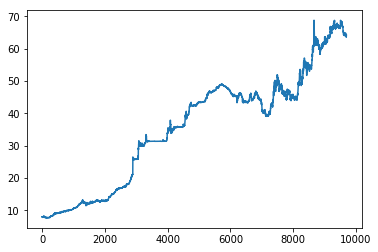

In [53]:

plt.plot(scaler.inverse_transform(price_dat))


#### In-sample Prediction:

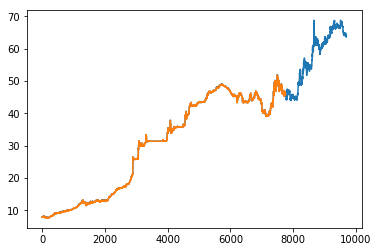

In [54]:
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(trainPredictPlot)


#### Out-sample Prediction:

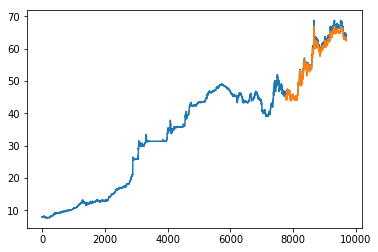

In [55]:
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(testPredictPlot)

# LSTM using Window Method

In [56]:
# reshape into X=t and Y=t+1
look_back = 3 # using past 3 values to predict the next

trainX, trainY = create_dataset(train_dat, look_back)
testX, testY = create_dataset(valid_dat, look_back)

In [57]:
print(trainX.shape)
print(trainY.shape)

(7754, 3)
(7754,)


In [58]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [59]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back))) # 4 in here means 4 LSTM blocks or neurons
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 37s - loss: 0.0042
Epoch 2/100
 - 36s - loss: 2.3494e-05
Epoch 3/100
 - 36s - loss: 2.0337e-05
Epoch 4/100
 - 38s - loss: 1.7058e-05
Epoch 5/100
 - 37s - loss: 1.4305e-05
Epoch 6/100
 - 36s - loss: 1.2627e-05
Epoch 7/100
 - 36s - loss: 1.2323e-05
Epoch 8/100
 - 36s - loss: 1.2148e-05
Epoch 9/100
 - 37s - loss: 1.2237e-05
Epoch 10/100
 - 35s - loss: 1.2135e-05
Epoch 11/100
 - 38s - loss: 1.2070e-05
Epoch 12/100
 - 38s - loss: 1.1470e-05
Epoch 13/100
 - 35s - loss: 1.1385e-05
Epoch 14/100
 - 37s - loss: 1.1216e-05
Epoch 15/100
 - 36s - loss: 1.1370e-05
Epoch 16/100
 - 36s - loss: 1.1260e-05
Epoch 17/100
 - 36s - loss: 1.1210e-05
Epoch 18/100
 - 36s - loss: 1.0598e-05
Epoch 19/100
 - 35s - loss: 1.0652e-05
Epoch 20/100
 - 36s - loss: 1.0771e-05
Epoch 21/100
 - 39s - loss: 1.0844e-05
Epoch 22/100
 - 48s - loss: 1.0444e-05
Epoch 23/100
 - 36s - loss: 1.0743e-05
Epoch 24/100
 - 35s - loss: 1.0426e-05
Epoch 25/100
 - 36s - loss: 1.0451e-05
Epoch 26/100
 - 36s - loss: 1.0271e-05

#### Prediction:

In [60]:
res_insp = model.predict(trainX)
res_outsp = model.predict(testX)

In [61]:
# inverse the transformation back to get the true value:
res_insp = scaler.inverse_transform(res_insp)
trainY = scaler.inverse_transform([trainY])

res_outsp = scaler.inverse_transform(res_outsp)
testY = scaler.inverse_transform([testY])

In [62]:
# RMSE:

trainScore = math.sqrt(mean_squared_error(trainY[0], res_insp[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], res_outsp[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.14 RMSE
Test Score: 4.17 RMSE


In [63]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(price_dat)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(res_insp)+look_back, :] = res_insp
# shift test predictions for plotting
testPredictPlot = np.empty_like(price_dat)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(res_insp)+(look_back*2)+1:len(price_dat)-1, :] = res_outsp
# plot baseline and predictions

#### Plotting:

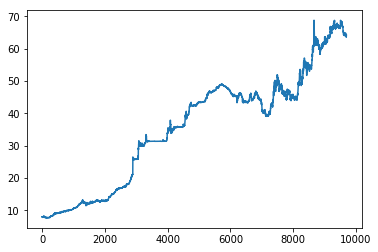

In [64]:
# Original data:
plt.plot(scaler.inverse_transform(price_dat))

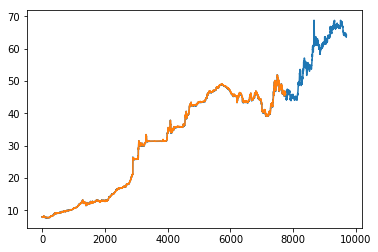

In [65]:
# In Sample Prediction:

plt.plot(scaler.inverse_transform(price_dat))
plt.plot(trainPredictPlot)


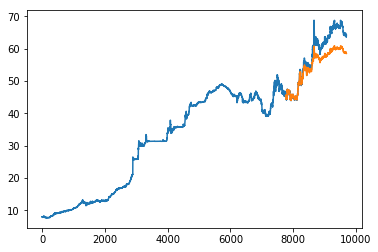

In [66]:
# Out Sample Prediction
plt.plot(scaler.inverse_transform(price_dat))
plt.plot(testPredictPlot)